# CVAE Pipeline
## Version 1.0
- Last Modified: 2025.5.20

In [1]:
from torch.utils.data import DataLoader
from dataset.data_loader import FontTransferDataset
from torch.utils.data import default_collate
# Define label space (62 characters)
label_space = [chr(i) for i in range(ord('0'), ord('9') + 1)] + \
              [chr(i) for i in range(ord('A'), ord('Z') + 1)] + \
              [chr(i) for i in range(ord('a'), ord('z') + 1)]

train_dataset = FontTransferDataset("./data/train_font_data.pkl", label_space)
valid_dataset = FontTransferDataset("./data/valid_font_data.pkl", label_space)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=default_collate)
valid_loader = DataLoader(valid_dataset, batch_size=64, collate_fn=default_collate)

In [2]:
len(train_dataset),len(valid_dataset)

(1400, 400)

In [3]:
train_dataset[0][0].shape, train_dataset[0][1].shape, train_dataset[0][2].shape
# style_img, label_onehot, target_img
# style_img: [1, 28, 28]
# label_onehot: [1, 62]
# target_img: [1, 28, 28]


(torch.Size([1, 28, 28]), torch.Size([62]), torch.Size([1, 28, 28]))

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from model import FontTransferCVAE, vae_loss

In [5]:
torch.mps.is_available()

True

In [9]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = FontTransferCVAE().to(device)

# Using AdamW optimizer, adding weight decay to prevent overfitting
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning rate scheduler, implementing learning rate decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

best_valid_loss = float('inf')
patience = 20
patience_counter = 0

num_epoch = 400
frq_print = 10
train_losses = []
valid_losses = []

In [10]:

for epoch in range(num_epoch):
    # Training phase
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0
    
    for style_img, label_onehot, target_img in train_loader:
        style_img, label_onehot, target_img = style_img.to(device), label_onehot.to(device), target_img.to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward pass
        recon, mu, logvar = model(style_img, label_onehot)
        loss, r_loss, kl = vae_loss(recon, target_img, mu, logvar)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent gradient explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        train_recon_loss += r_loss
        train_kl_loss += kl

    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)
    avg_train_recon = train_recon_loss / len(train_loader)
    avg_train_kl = train_kl_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    valid_loss = 0
    valid_recon_loss = 0
    valid_kl_loss = 0
    
    with torch.no_grad():
        for style_img, label_onehot, target_img in valid_loader:
            style_img, label_onehot, target_img = style_img.to(device), label_onehot.to(device), target_img.to(device)
            recon, mu, logvar = model(style_img, label_onehot)
            loss, r_loss, kl = vae_loss(recon, target_img, mu, logvar)
            valid_loss += loss.item()
            valid_recon_loss += r_loss
            valid_kl_loss += kl
    
    # Calculate average validation loss
    avg_valid_loss = valid_loss / len(valid_loader)
    avg_valid_recon = valid_recon_loss / len(valid_loader)
    avg_valid_kl = valid_kl_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    
    # Update learning rate
    scheduler.step(avg_valid_loss)
    
    if epoch % frq_print == 0: 
        print(f"Epoch {epoch+1}")
        print(f"Training Loss: {avg_train_loss:.4f} (Recon: {avg_train_recon:.4f}, KL: {avg_train_kl:.4f})")
        print(f"Validation Loss: {avg_valid_loss:.4f} (Recon: {avg_valid_recon:.4f}, KL: {avg_valid_kl:.4f})")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 50)
    
    # Early stopping check
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), "./data/best_cvae_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

Epoch 1
Training Loss: 0.1736 (Recon: 0.1596, KL: 0.0140)
Validation Loss: 0.0879 (Recon: 0.0869, KL: 0.0010)
Learning Rate: 0.001000
--------------------------------------------------
Epoch 11
Training Loss: 0.0642 (Recon: 0.0642, KL: 0.0000)
Validation Loss: 0.0645 (Recon: 0.0645, KL: 0.0000)
Learning Rate: 0.001000
--------------------------------------------------
Epoch 21
Training Loss: 0.0477 (Recon: 0.0477, KL: 0.0000)
Validation Loss: 0.0484 (Recon: 0.0484, KL: 0.0000)
Learning Rate: 0.001000
--------------------------------------------------
Epoch 31
Training Loss: 0.0407 (Recon: 0.0407, KL: 0.0000)
Validation Loss: 0.0417 (Recon: 0.0417, KL: 0.0000)
Learning Rate: 0.001000
--------------------------------------------------
Epoch 41
Training Loss: 0.0391 (Recon: 0.0391, KL: 0.0000)
Validation Loss: 0.0405 (Recon: 0.0405, KL: 0.0000)
Learning Rate: 0.001000
--------------------------------------------------
Epoch 51
Training Loss: 0.0385 (Recon: 0.0385, KL: 0.0000)
Validation L

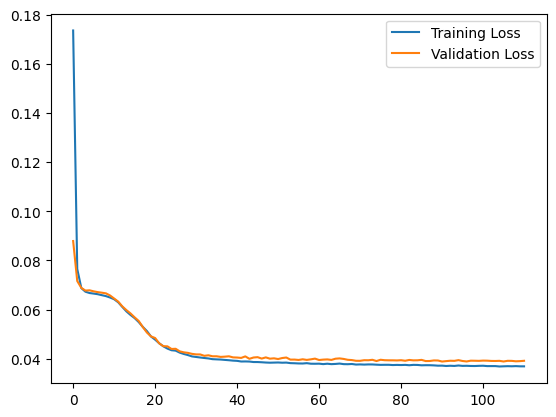

In [11]:
# print training and validation loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.legend()
plt.show()


In [12]:
# model.load_state_dict(torch.load("./data/cvae_font_transfer.pth"))
model.to(device)
model.eval()

FontTransferCVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=3136, out_features=256, bias=True)
    (6): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=64, bias=True)
  (decoder_input): Linear(in_features=126, out_features=256, bias=True)
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=3136, bias=True)
    (2): ReLU()
    (3): Unflatten(dim=1, unflattened_size=(64, 7, 7))
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [13]:
# from eval import *
test_dataset = FontTransferDataset("./data/test_font_data.pkl", label_space)
test_loader = DataLoader(test_dataset, batch_size=64)


In [14]:
for style_img, label_tensor, target_img in test_loader:
    print(style_img.shape)
    print(label_tensor.shape)
    print(target_img.shape)
    break

# torch.Size([64, 1, 28, 28])
# torch.Size([64, 62])
# torch.Size([64, 1, 28, 28])

torch.Size([64, 1, 28, 28])
torch.Size([64, 62])
torch.Size([64, 1, 28, 28])


In [15]:
test_dataset[0][0].shape, test_dataset[0][1].shape, test_dataset[0][2].shape
# style_img, label_onehot, target_img
# style_img: [1, 28, 28]
# label_onehot: [62]
# target_img: [1, 28, 28]


(torch.Size([1, 28, 28]), torch.Size([62]), torch.Size([1, 28, 28]))

In [16]:
import torch
import matplotlib.pyplot as plt

def label_to_onehot(label, label_space=label_space):
    """
    Convert a character label into a one-hot encoded tensor.

    Args:
        label (str): A single character, e.g., 'A'
        label_space (list of str): The list of allowed characters, length 62

    Returns:
        Tensor: One-hot encoded tensor of shape [62]
    """
    index = label_space.index(label)
    return torch.nn.functional.one_hot(torch.tensor(index), num_classes=len(label_space)).float()

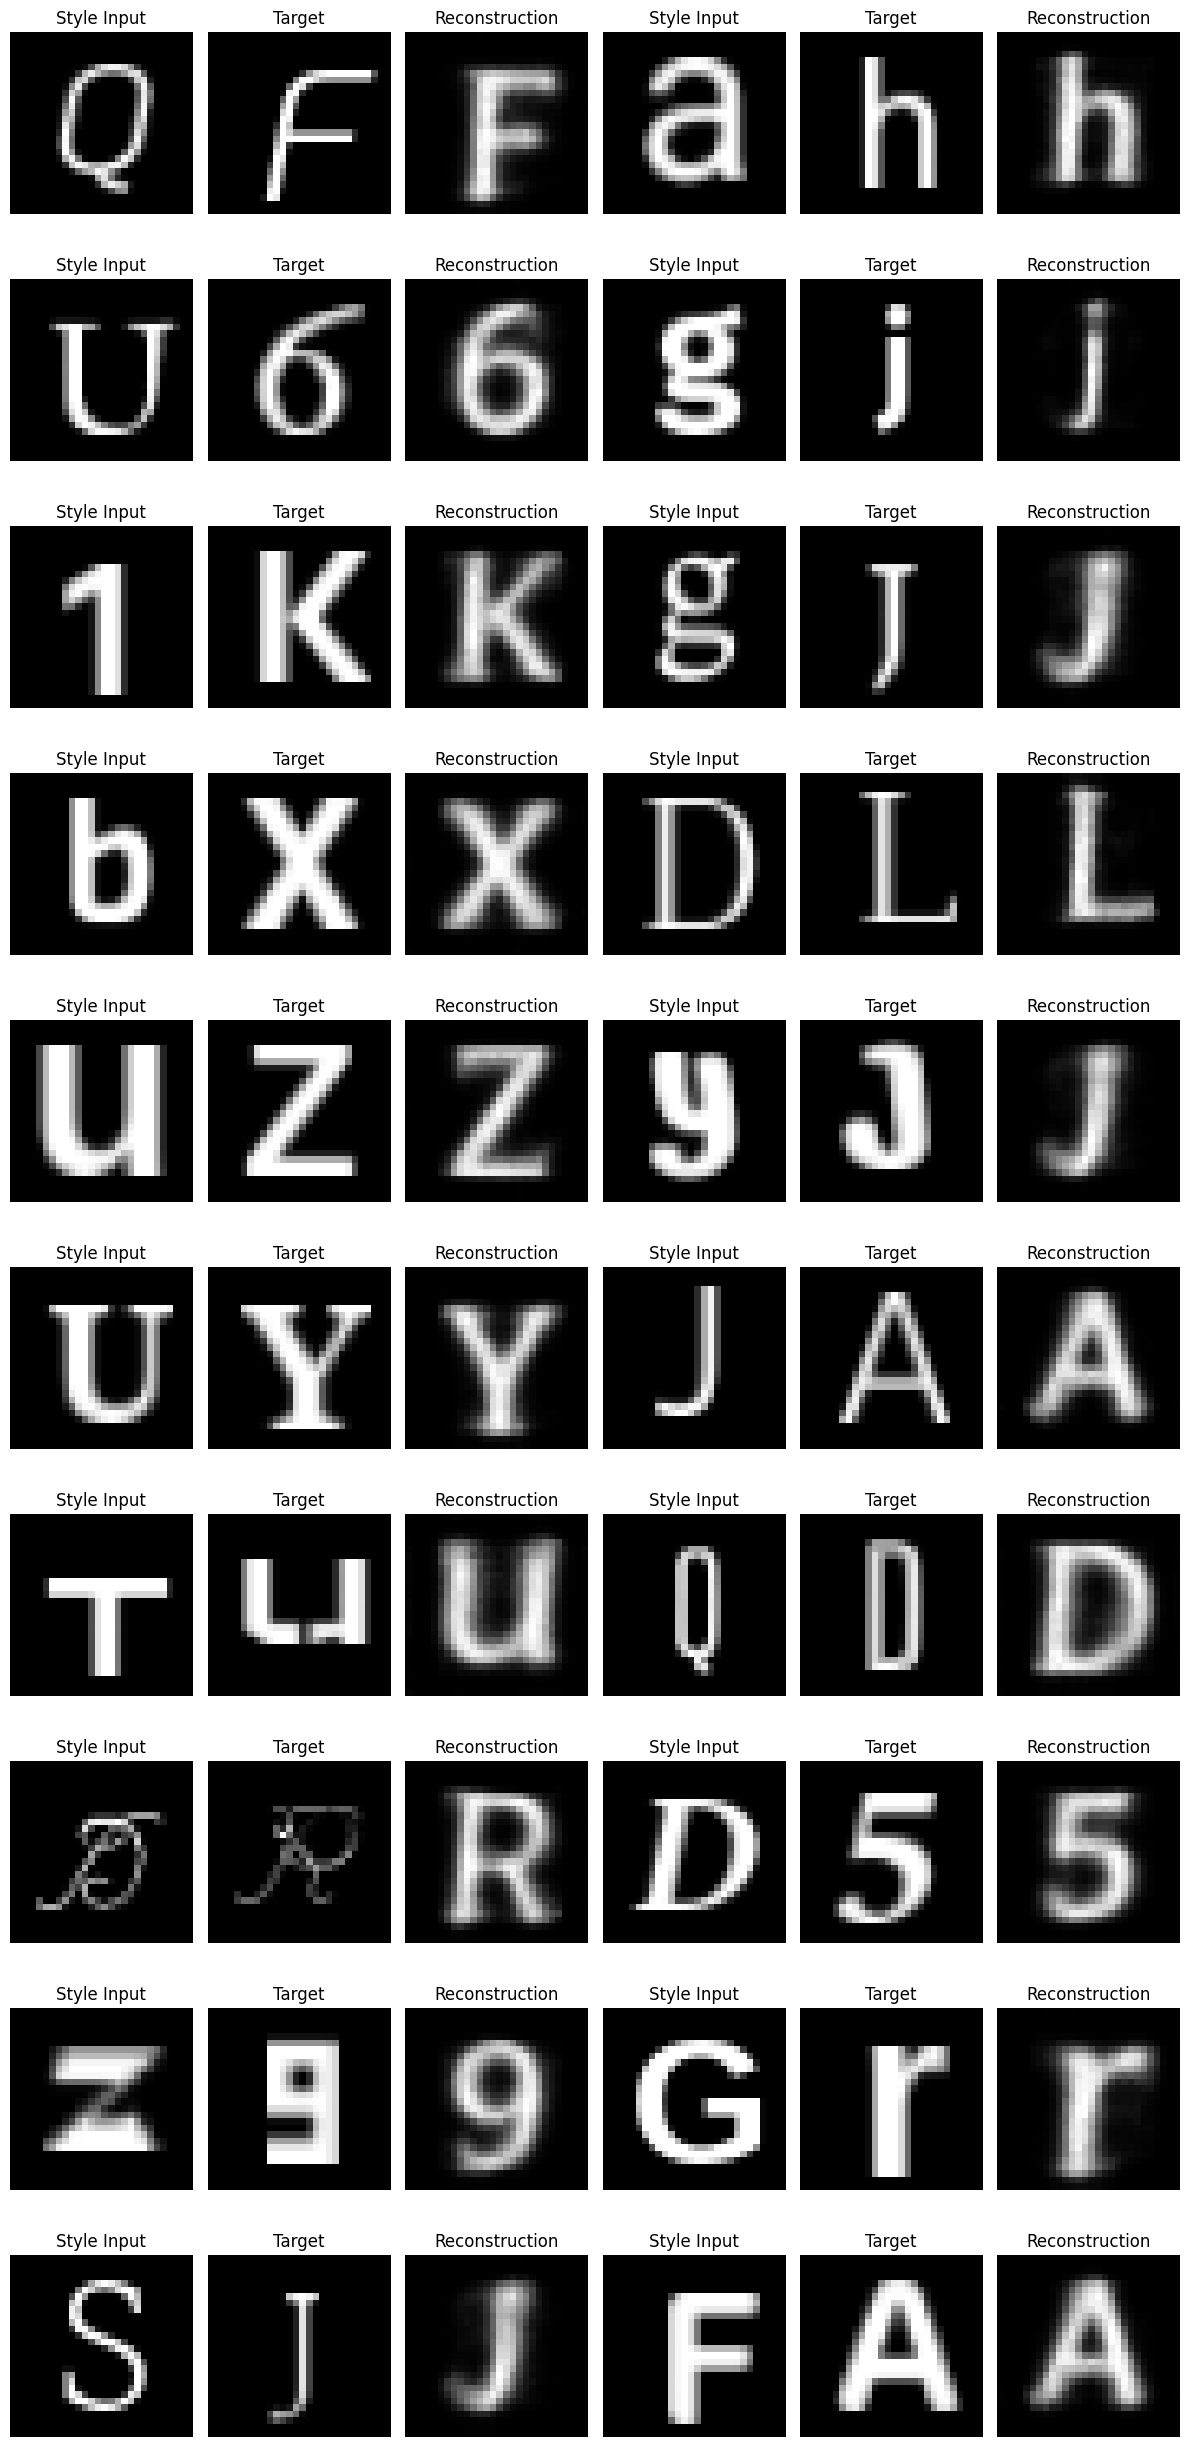

In [18]:
import torch
import matplotlib.pyplot as plt

samples_to_show = 20 # N
samples_per_row = 2
rows = samples_to_show // samples_per_row

fig, axes = plt.subplots(rows, 6, figsize=(12, 2.5 * rows))

model.eval()
with torch.no_grad():
    for style_img, label_tensor, target_img in test_loader:

        style_img = style_img[:samples_to_show].to(device)      # [N, 1, 28, 28]
        label_tensor = label_tensor[:samples_to_show].to(device)  # [N, 62]
        target_img = target_img[:samples_to_show].to(device)    # [N, 1, 28, 28]

        recon_img, _, _ = model(style_img, label_tensor)        # [N, 1, 28, 28]

        for i in range(samples_to_show):
            row = i // samples_per_row
            col = (i % samples_per_row) * 3
            
            axes[row, col].imshow(style_img[i].cpu().squeeze(), cmap='gray')
            axes[row, col].set_title("Style Input")

            axes[row, col+1].imshow(target_img[i].cpu().squeeze(), cmap='gray')
            axes[row, col+1].set_title("Target")

            axes[row, col+2].imshow(recon_img[i].cpu().squeeze(), cmap='gray')
            axes[row, col+2].set_title("Reconstruction")

            for j in range(3):
                axes[row, col+j].axis('off')

        break

plt.tight_layout()
plt.show()